In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 실습2. Sub-Gradient method

데이터 셋 "diabetes2.csv"에 대해서 로지스틱 회귀모델 $ y= g(\beta_0 + \beta_1 x_1 + \beta_2 x_2 \cdots) \quad  ; g(t) = \frac{1}{1+exp(-t)}$을 가정한 후 다음 문제를 풀어보아라.

문제 A. 제약이 없는 MLE를 Gradient Descent 방법으로 풀어보자.   
문제 B. A에 L2-Penalty를 추가하여 Gradient Descent 방법으로 풀어보자.   
문제 C. A에 L1-Penalty를 추가하여 Sub Gradient 방법으로 풀어보자. 


## 문제 0. 데이터 셋 만들기

우선 데이터 셋을 불러오자.  

알고리즘을 짤때, Pandas DataFrame이냐 Numpy Array이냐에 따라서 연산이 조금씩 달라지기 때문에 하나로 통일해주자. 여기서는 Numpy Array로 통일해 주었다.  

실습1에서 스케일 문제는 수렴의 불균형에 영향을 준다고 하였다. 따라서 스케일링을 한 다음에 구현을 진행하자.  
이전과 마찬가지로 StandardScaler를 활용하였다. 

In [98]:
data = pd.read_csv("diabetes2.csv")
x_mat = data.iloc[:,:-1].values
y_mat = data.iloc[:,-1].values

from sklearn import preprocessing 
x_mat = preprocessing.scale(x_mat)
x_mat = np.concatenate((np.ones((np.shape(x_mat)[0],1)),x_mat),axis=1)

## 문제 A. 제약이 없는 MLE를 Gradient Descent 방법으로 풀어보자.

실습 1에서는 단순히 다중 선형회귀모델의 계수를 적합시키는 것이 목표였고, 목적함수를 오차의 L2 Norm으로 둬서 잘 추정할 수 있었다.  
그러나 이번에 가정된 로지스틱 회귀모델은 오차를 L2 Norm으로 측정하기가 어렵다.  



따라서 로지스틱 회귀모델은 다음과 같은 통계적 모델을 가정하여 MLE를 이용해서 풀어낸다.  

$$y_i \sim Benoulli(\theta_i) \\ \frac{\theta_i}{1-\theta_i} = X_i \beta + \epsilon_i \\ \Rightarrow \theta_i = \frac{exp(X_i \beta)}{1+exp(X_i \beta)} + \epsilon_i' \\ \Rightarrow  \theta_i = g(X_i \beta) +\epsilon_i'$$




이에 대해서 데이터 $D$와 모수 $\beta$의 log-Likelihood는 다음과 같다.  
$$log L(\beta;D) \\ = log \prod Pr(y_i;\theta_i) = \sum log Pr(y_i ; \theta_i) \\ = \sum \{ log \theta_i^{y_i} + log (1-\theta_i)^{(1-y_i)}\} \\ = \sum \{ y_i log \frac{\theta_i}{1-\theta_i} + log (1-\theta_i) \} \\ = \sum \{ y_i log( \frac{exp(X_i \beta)/(1+exp(X_i \beta)}{1/(1+exp(X_i \beta)} ) + log (1/(1+exp(X_i \beta)) \} \\ =\sum \{ y_i X_i \beta -log (1+exp(X_i\beta)) \}$$

따라서 주어진 optimization 문제를 도식화 하면 다음과 같다.  

$$\quad max \quad log L(\beta;D) \\ \Rightarrow \quad   min \quad - log L(\beta;D) \\  \Rightarrow  \quad min \sum \{-y_iX_i\beta + log(1+exp(X_i\beta))\}$$  

즉 목적함수는 $f_A(\beta) = \sum \{-y_iX_i\beta + log(1+exp(X_i\beta))\}$가 된다.   

**이렇게 찾은 함수를 이용하여 $\beta$를 넣으면 Cost를 구해주는 함수를 정의해보자.**

In [99]:
def logit(x) : 
    return(1/(1+np.exp(-x)))

def cost_A(beta) : 
    return(-y_mat.T@x_mat@beta +sum(np.log(1+np.exp(x_mat@beta))))

다음으로 함수의 Gradient를 계산하면 다음과 같다.  
$\nabla f_A(\beta) = \sum \{ -y_iX_i^t + \frac{exp(X_i\beta)}{1+exp(X_i\beta)}X_i^t \} \\ \qquad =  \sum \{( -y_i + \frac{exp(X_i\beta)}{1+exp(X_i\beta)})X_i^t \}$   

**이를 이용하여 $\beta$를 넣으면 현재의 Gradient를 계산해주는 함수를 정의해보자.**

In [100]:
def gradient_A(beta) :
    return(sum((-y_mat.reshape(-1,1)+logit(x_mat@beta)).T@x_mat).reshape(-1,1))

BackTracking Line Search의 Condition은 다음과 같다.  
$$f(\beta^+) > f(\beta) - \alpha t \parallel \nabla f(\beta) \parallel_2^2$$  

**위에서 구한 식들을 활용하여 Backtracking Line Search Condition을 확인해주는 함수를 짜보자.**

In [101]:
def backtracking_A(t) :
    beta_plus = beta_temp-t*gradient_A(beta_temp)
    LS = cost_A(beta_plus)
    RS = cost_A(beta_temp)-alpha*t*sum(gradient_A(beta_temp)**2)
    return(LS>RS)

Gradient Descent에서는 Gradient가 충분히 작아졌을때 얼리스타핑을 해줄 수 있다. 일반적으로 L2-Norm을 쓰며 이를 표현하면 다음과 같다.  
$$\mbox{Stop if } \parallel \nabla f(\beta) \parallel_2 < \epsilon$$  

여기서 $\epsilon$은 적절한 상수이다.  

**얼리스타핑 conditon을 확인해주는 함수를 짜보자.**

In [102]:
def earlystopping_A(beta,goal) :
    return(np.linalg.norm(gradient_A(beta))<goal)

이제 위에서 정의한 함수를 기반으로 하여 Gradient Descent를 짜줄수 있다.  

Gradient Descent를 돌리기 위해 필요한 초기값과 Hyper Parameter는 1.모수의 초기값, 2.현재 모수값의 Placeholer, 3.스텝사이즈 초기값, 3.현재 스텝사이즈의 Placeholder, 4.Backtracking Line Search의 Hyper Parameter $\alpha$와 $\beta$, 5.얼리스타핑의 기준이 되어줄 tolerance 들이다. 이를 모두 정의해주자. 

**우선 Gradient Descent를 돌리기 전 초기 설정값들을 정의해주자.**

In [103]:
## 초기값
beta_init = np.array([1,1,1,1,1,1,1,1,1]).reshape(9,1)
t_init = 10

## 현재값
beta_temp = beta_init
t_temp = t_init

## 전체 결과물 저장소
GD_result_A = [cost_A(beta_temp).tolist()+[t_temp]+beta_temp.T.tolist()[0]]

## BackTracking Hyperparameter
alpha = 0.5
beta = 0.7

## Early Stopping Hyperparameter
tol = 1

Backtracking Line Search를 이용한 Gradient Descent의 알고리즘은 다음과 같다.  
1. backtracking condition이 깨질 때까지 step size t를 beta의 비율만큼 축소해주기 
2. $x^+ = x - t \nabla f(x)$를 통해 새로운 값 $x^+$를 찾기
3. 현재의 변수값과 StepSize, Cost 등을 정해주기
4. Early Stopping 기준을 충족했는지 확인한 후 충족하지 못했다면 1로 회귀하고 충족했다면 중단  

**이를 코드로 구현하면 다음과 같다.**

In [106]:
for i in range(10000) :
    while backtracking_A(t_temp) :
        t_temp = t_temp * beta
    beta_temp = beta_temp - t_temp*gradient_A(beta_temp)
    GD_result_A = np.append(GD_result_A,[cost_A(beta_temp).tolist()+[t_temp]+beta_temp.T.tolist()[0]],axis=0)
    if earlystopping_A(beta_temp,tol) : break
GD_result_A = pd.DataFrame(GD_result_A,columns=["cost","t_step","beta0","beta1","beta2","beta3","beta4","beta5","beta6","beta7","beta8"])

**Gradient Descent 결과물을 확인해보자.**

In [15]:
GD_result_A

,cost,t_step,beta0,beta1,beta2,beta3,beta4,beta5,beta6,beta7,beta8
0,866.720916,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,379.218417,0.011399,-0.973677,0.516779,1.187144,-0.311791,-0.257624,0.139611,0.478495,0.592219,0.359042
2,365.506140,0.005585,-0.939247,0.408320,1.140585,-0.266049,-0.106597,0.056369,0.653294,0.464528,0.199691
3,362.611854,0.005585,-0.903952,0.422112,1.111168,-0.250980,-0.086036,-0.049792,0.691542,0.377948,0.193026
4,361.979125,0.005585,-0.885605,0.414749,1.104840,-0.246244,-0.047661,-0.081657,0.714159,0.343741,0.177068
5,361.819451,0.005585,-0.877381,0.416187,1.104590,-0.247812,-0.030763,-0.104006,0.717316,0.326397,0.175765
6,361.766833,0.005585,-0.873695,0.415375,1.107571,-0.250019,-0.017443,-0.114275,0.717343,0.319215,0.174437
7,361.744771,0.005585,-0.872184,0.415366,1.110723,-0.252134,-0.009486,-0.121418,0.715349,0.315756,0.174636
8,361.734168,0.005585,-0.871524,0.415106,1.113634,-0.253659,-0.003767,-0.125840,0.713471,0.314253,0.174732
9,361.728755,0.005585,-0.871254,0.414973,1.115992,-0.254746,0.000094,-0.129013,0.711800,0.313534,0.174897


적당히 잘 수렴한 것 같고 Cost Function은 866에서 361까지로 줄어들었다.  
이 결과물을 시각화 해보자. 

In [107]:
def draw_convergence(variable,data) :
    sns.lineplot(x=data.index, y=variable,
                  sort=False, data=data)
    sns.scatterplot(x=data.index, y=variable,data=data,s=50,marker="o")

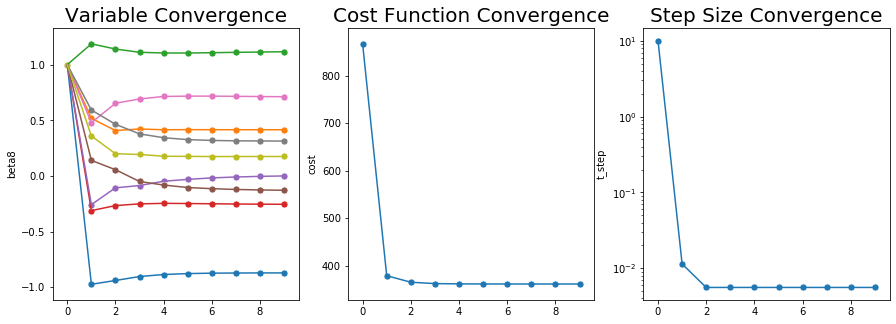

In [19]:
plt.figure(figsize=(15,5))

plt.subplot(131)

draw_convergence("beta0",GD_result_A)
draw_convergence("beta1",GD_result_A)
draw_convergence("beta2",GD_result_A)
draw_convergence("beta3",GD_result_A)
draw_convergence("beta4",GD_result_A)
draw_convergence("beta5",GD_result_A)
draw_convergence("beta6",GD_result_A)
draw_convergence("beta7",GD_result_A)
draw_convergence("beta8",GD_result_A)
plt.title("Variable Convergence",fontsize=20)


plt.subplot(132)

draw_convergence("cost",GD_result_A)
plt.title("Cost Function Convergence",fontsize=20)

plt.subplot(133)

draw_convergence("t_step",GD_result_A)
plt.yscale("log")
plt.title("Step Size Convergence",fontsize=20)

plt.show()

변수들과 Cost Function이 무사이 수렴한 모습을 볼 수 있다.  

그러나 이값들이 정말로 신뢰성이 있는 값들인지 알아보기 위해서 SK-learn에 있는 Logistic Regression 함수를 사용해서 다시 체크를 해보았다. 

In [20]:
from sklearn.linear_model import LogisticRegression
lr_A = LogisticRegression(fit_intercept=False)
lr_A.fit(x_mat,y_mat)
lr_A.coef_

array([[-0.85880471,  0.40796967,  1.10556381, -0.25048242,  0.00914831,
        -0.13090206,  0.6944184 ,  0.308601  ,  0.17575565]])

값들이 거의 유사함을 확인할 수 있다. 

## 문제 B. A에 L2-Penalty를 추가하여 Gradient Descent 방법으로 풀어보자.   

L2- Penalty가 추가된다면 목적함수의 꼴이 약간 달라진다. 구체적으로 다음과 같다. 

$$f_{B}(\beta) = f_{A}(\beta) + \lambda \parallel \beta \parallel_2  \\ = \sum \{ y_i X_i \beta -log (1+exp(X_i\beta)) \} + \lambda \parallel \beta \parallel_2 $$

이를 이용해서 CostFunciton을 새로 정의해보자

In [109]:
def cost_B(beta,lamda) : 
    return(-y_mat.T@x_mat@beta +sum(np.log(1+np.exp(x_mat@beta)))+lamda * np.linalg.norm(beta))

이 목적함수의 Gradient를 구하면 다음과 같다.  

$$\nabla f_B(\beta) = \nabla(f_A(\beta)+\lambda \parallel \beta \parallel_2) \\ \qquad = \nabla f_A(\beta) + \nabla \lambda \parallel \beta \parallel_2 \\ \qquad = \nabla f_A(\beta) + \lambda \beta \\ =  \sum \{( -y_i + \frac{exp(X_i\beta)}{1+exp(X_i\beta)})X_i^t \} + \lambda \beta$$  

Gradient의 전반부는 앞서서 구한것과 똑같은 모습이다. 따라서 앞의 것에 약간만 추가해줌으로써 구현할 수 있다.  

**$\nabla f_B(\beta)$를 함수로 정의해보자.**

In [110]:
def gradient_B(beta,lamda) :
    return(sum((-y_mat.reshape(-1,1)+logit(x_mat@beta)).T@x_mat).reshape(-1,1)+lamda*beta)

**앞선 문제에서 했던 것처럼 BackTracking Condtion과 Early Stopping Condition을 체크해주는 함수를 정의하자.**

In [112]:
def backtracking_B(t,lamda) :
    beta_plus = beta_temp-t*gradient_B(beta_temp,lamda)
    LS = cost_B(beta_plus,lamda)
    RS = cost_B(beta_temp,lamda)-alpha*t*sum(gradient_B(beta_temp,lamda)**2)
    return(LS>RS)

def earlystopping_B(beta,lamda,goal) :
    return(np.linalg.norm(gradient_B(beta,lamda))<goal)

**마찬가지로 초기설정을 지정해주자.**

In [115]:
## 초기값
beta_init = np.array([1,1,1,1,1,1,1,1,1]).reshape(9,1)
t_init = 10

## 현재값
beta_temp = beta_init
t_temp = t_init

## Penalty Function Hyperparameter
lamda = 10

## 전체 결과물 저장소
GD_result_B = [cost_B(beta_temp,lamda = 10).tolist()+[t_temp]+beta_temp.T.tolist()[0]]

## BackTracking Hyperparameter
alpha = 0.5
beta = 0.7

## Early Stopping Hyperparameter
tol = 11

**Gradient Descent를 돌려보자.**

In [116]:
for i in range(10000) :
    while backtracking_B(t_temp,lamda) :
        t_temp = t_temp * beta
    beta_temp = beta_temp - t_temp*gradient_B(beta_temp,lamda)
    GD_result_B = np.append(GD_result_B,[cost_B(beta_temp,lamda).tolist()+[t_temp]+beta_temp.T.tolist()[0]],axis=0)
    if earlystopping_B(beta_temp,lamda,tol) : break
GD_result_B = pd.DataFrame(GD_result_B,columns=["cost","t_step","beta0","beta1","beta2","beta3","beta4","beta5","beta6","beta7","beta8"])

C:\Users\User\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


**결과물을 확인해보자.**

In [117]:
GD_result_B

,cost,t_step,beta0,beta1,beta2,beta3,beta4,beta5,beta6,beta7,beta8
0,896.720916,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,406.311886,0.011399,-1.087666,0.402790,1.073155,-0.425780,-0.371613,0.025622,0.364506,0.478230,0.245053
2,383.281980,0.003910,-0.931849,0.386368,1.088096,-0.263151,-0.142237,0.073183,0.565069,0.426053,0.214159
3,379.631772,0.003910,-0.862613,0.381641,1.041962,-0.229388,-0.092225,0.008793,0.607562,0.364585,0.196105
4,378.509512,0.003910,-0.823497,0.376088,1.011542,-0.215311,-0.061528,-0.031322,0.622807,0.327347,0.184723
5,378.199430,0.003910,-0.800869,0.372068,0.994334,-0.208700,-0.040770,-0.053808,0.626663,0.305910,0.179524


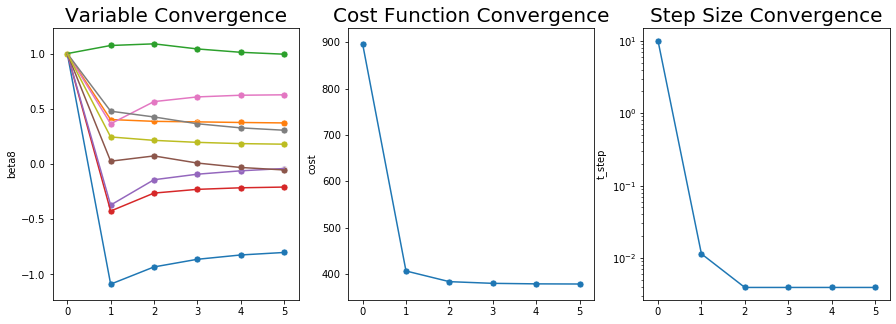

In [40]:
plt.figure(figsize=(15,5))

plt.subplot(131)

draw_convergence("beta0",GD_result_B)
draw_convergence("beta1",GD_result_B)
draw_convergence("beta2",GD_result_B)
draw_convergence("beta3",GD_result_B)
draw_convergence("beta4",GD_result_B)
draw_convergence("beta5",GD_result_B)
draw_convergence("beta6",GD_result_B)
draw_convergence("beta7",GD_result_B)
draw_convergence("beta8",GD_result_B)
plt.title("Variable Convergence",fontsize=20)

plt.subplot(132)

draw_convergence("cost",GD_result_B)
plt.title("Cost Function Convergence",fontsize=20)

plt.subplot(133)

draw_convergence("t_step",GD_result_B)
plt.yscale("log")
plt.title("Step Size Convergence",fontsize=20)

plt.show()

A번과 마찬가지로 수렴이 잘 된 모습을 확인할 수 있다. 

## 문제 C. A에 L1-Penalty를 추가하여 Sub Gradient 방법으로 풀어보자. 

L2와 마찬가지로 L1-Penalty가 추가된다면 목적함수가 다음과 같이 바뀐다.  
$$f_C(\beta) = f_A(\beta) + \lambda \parallel \beta \parallel_1 \\ = \sum \{ y_i X_i \beta -log (1+exp(X_i\beta)) \} + \lambda \parallel \beta \parallel_1 $$

**마찬가지로 이를 이용해서 Cost Function을 구현해주자.**

In [119]:
def cost_C(beta,lamda) : 
    return(-y_mat.T@x_mat@beta +sum(np.log(1+np.exp(x_mat@beta)))+lamda * np.linalg.norm(beta,1))

그러나 앞선 경우와는 다르게 $\parallel \beta \parallel_1$ 는 미분이 불가능하다.  
이 경우에는 일반적인 Gradient Descent가 아니라 Subgradient를 이용해줘서 문제를 풀어줘야 한다.  

subgradient의 정의는 다음과 같다.  

> Subgradient of $f(x)$ = $\partial f(x)$  
$f(x)$에 대해 $f(y) \geq f(x) +g \cdot (y-x)$를 만족하는 g의 집합

즉 일반적으로 미분가능할 때는 $g= \{\nabla f(x) \}$ 이지만 미분이 불가능한 Convex Function에서는 이를 대신할 수들을 계산해서 Gradient를 대체할 수 있다는 의미이다.  

이러한 Subgradient를 계산하면 다음과 같다.  

$$\partial f_C(\beta) = \partial\{f_A(\beta) + \lambda \parallel \beta \parallel_1\} \\ \qquad = \partial f_A(\beta) + \lambda \partial(\parallel \beta \parallel_1) \\ \qquad = \nabla f_A(\beta) + \lambda \partial(\parallel \beta \parallel_1)$$

$\parallel \beta \parallel_1$의 subgradient는 다음과 같다.  

$$\partial \parallel \beta \parallel_1 = \begin{cases} 1 \qquad \mbox{ if }\beta_i >0  \\ -1 \qquad \mbox{ if }\beta_i \mbox{<0} \\ [-1,1] \quad \mbox{ if }\beta_j =0   \end{cases} $$  

**이를 이용하여 Subradient를 계산해주는 함수를 구현해보자.**

In [120]:
def l1_subgradient(beta) : 
    sub_placeholder = np.zeros(np.shape(beta)[0])
    for i in range(np.shape(beta)[0]) :
        if beta[i] > 0 : sub_placeholder[i] = 1
        elif beta[i] <0 : sub_placeholder[i] = -1
        else : sub_placeholder[i] = 0
    return(sub_placeholder.reshape(-1,1))

def gradient_C(beta,lamda) :
    return(sum((-y_mat.reshape(-1,1)+logit(x_mat@beta)).T@x_mat).reshape(-1,1)+lamda*l1_subgradient(beta))


**나머지는 앞서서와 똑같이 해주면 된다.**

In [121]:
def backtracking_C(t,lamda) :
    beta_plus = beta_temp-t*gradient_C(beta_temp,lamda)
    LS = cost_C(beta_plus,lamda)
    RS = cost_C(beta_temp,lamda)-alpha*t*sum(gradient_C(beta_temp,lamda)**2)
    return(LS>RS)

def earlystopping_C(beta,lamda,goal) :
    return(np.linalg.norm(gradient_C(beta,lamda))<goal)

In [122]:
## 초기값
beta_init = np.array([1,1,1,1,1,1,1,1,1]).reshape(9,1)
t_init = 10

## 현재값
beta_temp = beta_init
t_temp = t_init

## Penalty Function Hyperparameter
lamda = 10

## 전체 결과물 저장소
GD_result_C = [cost_C(beta_temp,lamda = 10).tolist()+[t_temp]+beta_temp.T.tolist()[0]]

## BackTracking Hyperparameter
alpha = 0.5
beta = 0.7

## Early Stopping Hyperparameter
tol = 15

In [124]:
for i in range(1000) :
    while backtracking_C(t_temp,lamda) :
        t_temp = t_temp * beta
    beta_temp = beta_temp - t_temp*gradient_C(beta_temp,lamda)
    GD_result_C = np.append(GD_result_C,[cost_C(beta_temp,lamda).tolist()+[t_temp]+beta_temp.T.tolist()[0]],axis=0)
    if earlystopping_C(beta_temp,lamda,tol) : break
GD_result_C = pd.DataFrame(GD_result_C,columns=["cost","t_step","beta0","beta1","beta2","beta3","beta4","beta5","beta6","beta7","beta8"])

**이제 결과를 살펴보자.**

In [90]:
GD_result_C

,cost,t_step,beta0,beta1,beta2,beta3,beta4,beta5,beta6,beta7,beta8
0,956.720916,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,433.059973,0.011399,-1.087666,0.402790,1.073155,-0.425780,-0.371613,0.025622,0.364506,0.478230,0.245053
2,401.513642,0.005585,-0.869967,0.345973,1.098585,-0.161380,-0.008834,0.039143,0.615530,0.374548,0.158751
3,398.460663,0.002737,-0.839947,0.345845,1.061399,-0.156812,-0.006009,-0.050095,0.595604,0.322457,0.147104
4,397.744561,0.002737,-0.813577,0.341487,1.039692,-0.148860,0.013290,-0.048432,0.583961,0.288160,0.135570
5,397.322081,0.001916,-0.799675,0.340057,1.027558,-0.144562,-0.015623,-0.048115,0.575453,0.270480,0.131018


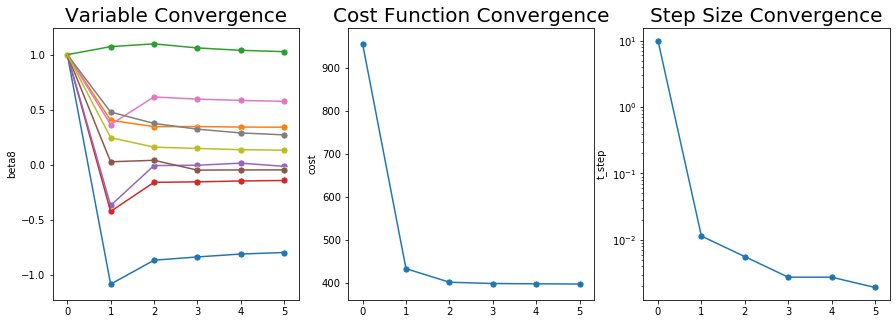

In [91]:
plt.figure(figsize=(15,5))

plt.subplot(131)

draw_convergence("beta0",GD_result_C)
draw_convergence("beta1",GD_result_C)
draw_convergence("beta2",GD_result_C)
draw_convergence("beta3",GD_result_C)
draw_convergence("beta4",GD_result_C)
draw_convergence("beta5",GD_result_C)
draw_convergence("beta6",GD_result_C)
draw_convergence("beta7",GD_result_C)
draw_convergence("beta8",GD_result_C)
plt.title("Variable Convergence",fontsize=20)


plt.subplot(132)

draw_convergence("cost",GD_result_C)
plt.title("Cost Function Convergence",fontsize=20)

plt.subplot(133)

draw_convergence("t_step",GD_result_C)
plt.yscale("log")
plt.title("Step Size Convergence",fontsize=20)

plt.show()

결과를 보니 잘 수렴한 것을 알 수 있다. 